In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification,create_optimizer
from transformers import glue_convert_examples_to_features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import re
from tensorflow.keras.utils import to_categorical
import string

In [2]:
# Load dataset
df = pd.read_csv("Eclipse_Platform.csv")

In [3]:
# preprocess_text function
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'stack trace\S+', '', text)  # Remove stack traces
    text = re.sub(r'\b[0-9a-fA-F]+\b', '', text)  # Remove hex codes
    text = re.sub(r'\[.*?\]', '', text)  # Remove content in square brackets
    text = re.sub(r'<.*?>', '', text)  # Remove content in angle brackets
    text = text.replace('@', '')  # Remove @
    text = text.replace('-', '')  # Remove -
    text = text.replace('"', '')  # Remove "
    text = text.replace('`', '')  # Remove `
    text = text.replace('[', '')  # Remove [
    text = text.replace(']', '')  # Remove ]
    text = text.replace('<', '')  # Remove <
    text = text.replace('>', '')  # Remove >
    text = text.replace('%', '')  # Remove %
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\r\n', ' ', text)  # Replace Windows-style newlines with space
    text = re.sub(r'\n|\r', ' ', text)  # Replace Unix/Mac-style newlines with space
    # tokens = word_tokenize(text)  # Tokenization
    # lemmatizer = WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # text = ' '.join(tokens)  # Join tokens back to string
    return text

df["text"] = df["title"] + " " + df["description"]
df["text"] = df["text"].apply(preprocess_text)
df["component"] = df["component"].apply(preprocess_text)


In [4]:
df.tail(25)

,component,title,description,text
8432,team,FTP: Connection wizard has no title,Build F2\n\nWhen you are specifying your FTP c...,ftp connection wizard has no title build whe...
8433,ant,Ant Editor image does not update when problem ...,"If you have a problem that you set to ignore, ...",ant editor image does not update when problem ...
8434,user assistance,"2 additional points for the ""Accessibility fea...","As a follow-on to bug 400997 comment 9, there ...",additional points for the accessibility featu...
8435,ui,[Jobs] Property IProgressConstants2.SHOW_IN_TA...,Created attachment 254799 [details]\nA test pr...,property iprogressconstantsshowintaskbariconp...
8436,ant,Hidden functionality of the copy button for bu...,From the newsgroup:\n> I expected that button ...,hidden functionality of the copy button for bu...
8437,compare,Exceptions after one of the compare viewer inp...,Build I20030513\n\n1. Select two folders\n2. C...,exceptions after one of the compare viewer inp...
8438,swt,NullPointerException when invoking ContentAssist,eclipse.buildId=I20090313-0100\njava.version=1...,nullpointerexception when invoking contentassi...
8439,ant,NullPointerException opening Ant file with URL...,"Since upgrading to Mars, the following build f...",nullpointerexception opening ant file with url...
8440,ant,Code folding in the Ant Editor,Utilize the text framework support for code fo...,code folding in the ant editor utilize the tex...
8441,ant,Code completion does not present nested target...,antcall has supported a nested target element ...,code completion does not present nested target...


In [5]:

component_counts = df['component'].value_counts()
print(component_counts)


component
swt                                             994
debug                                           994
ant                                             994
ui                                              994
team                                            929
releng                                          733
text                                            630
cvs                                             523
compare                                         356
ide                                             315
resources                                       273
user assistance                                 248
doc                                             180
search                                          144
runtime                                          93
update  deprecated  use eclipseequinoxp          57
Name: count, dtype: int64


In [6]:
df.shape[0]

8457

In [7]:
# Splitting the data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# # Convert labels to one-hot encoding
# y_train = to_categorical(y_train, num_classes=num_classes)
# y_test = to_categorical(y_test, num_classes=num_classes)

In [9]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
# max_length = 512

In [11]:
def encode_data(tokenizer, texts, labels, max_length):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True, 
            max_length=max_length, 
            truncation=True, 
            padding='max_length', 
            return_attention_mask=True, 
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'labels': labels
    }

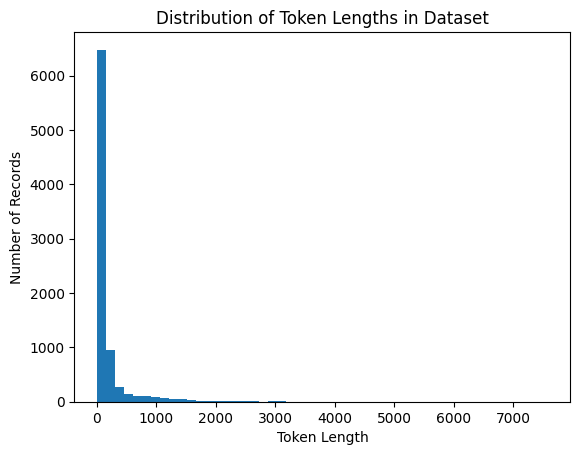

90th percentile: 400.0
95th percentile: 903.1999999999998
99th percentile: 1999.0800000000036


In [12]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text and get lengths
token_lengths = []
for text in df['text']:
    tokens = tokenizer.tokenize(text)
    token_lengths.append(len(tokens))

# Analyze the distribution
import matplotlib.pyplot as plt

plt.hist(token_lengths, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Number of Records')
plt.title('Distribution of Token Lengths in Dataset')
plt.show()

# Print percentile values to help decide on max_length
for percentile in [90, 95, 99]:
    print(f"{percentile}th percentile: {np.percentile(token_lengths, percentile)}")


In [13]:
# Assuming 'Component' is the column you're predicting
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['component'])
test_labels = label_encoder.transform(test_data['component'])

In [14]:
max_length = 50  
train_encodings = encode_data(tokenizer, train_data['text'].to_numpy(), train_labels, max_length)
test_encodings = encode_data(tokenizer, test_data['text'].to_numpy(), test_labels, max_length)


In [15]:
# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)


In [16]:
# Load the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['component'].unique()))


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(64)

In [18]:
# Prepare the validation dataset
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(64)

In [19]:
# Optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=8)

Epoch 1/8
106/106 [==============================] - 438s 4s/step - loss: 1.7964 - accuracy: 0.5132 - val_loss: 1.6681 - val_accuracy: 0.5449
Epoch 2/8
106/106 [==============================] - 437s 4s/step - loss: 1.5953 - accuracy: 0.5614 - val_loss: 1.5231 - val_accuracy: 0.5721
Epoch 3/8
106/106 [==============================] - 436s 4s/step - loss: 1.4361 - accuracy: 0.6058 - val_loss: 1.4345 - val_accuracy: 0.5792
Epoch 4/8
106/106 [==============================] - 435s 4s/step - loss: 1.3039 - accuracy: 0.6420 - val_loss: 1.3529 - val_accuracy: 0.5963
Epoch 5/8
106/106 [==============================] - 437s 4s/step - loss: 1.1909 - accuracy: 0.6724 - val_loss: 1.2949 - val_accuracy: 0.6152
Epoch 6/8
106/106 [==============================] - 437s 4s/step - loss: 1.0828 - accuracy: 0.7045 - val_loss: 1.2485 - val_accuracy: 0.6294
Epoch 7/8
106/106 [==============================] - 434s 4s/step - loss: 0.9889 - accuracy: 0.7307 - val_loss: 1.2167 - val_accuracy: 0.6294
Epoch 

In [22]:
# Evaluate the model
eval_results = model.evaluate(test_dataset)
print(f'\nTest Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}')


27/27 [==============================] - 26s 978ms/step - loss: 1.1970 - accuracy: 0.6348

Test Loss: 1.1969578266143799, Test Accuracy: 0.6347517967224121


In [24]:
from sklearn.metrics import accuracy_score, classification_report

# Prediction on test data
predictions = model.predict(test_dataset).logits
test_preds = np.argmax(predictions, axis=1)

# Convert predictions to original labels
test_preds_original = label_encoder.inverse_transform(test_preds)

# Accuracy and classification report
accuracy = accuracy_score(test_data['component'], test_preds_original)
classification_report_result = classification_report(test_data['component'], test_preds_original)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report_result)

27/27 [==============================] - 26s 964ms/step
Accuracy: 0.6347517730496454
Classification Report:
                                              precision    recall  f1-score   support

                                    ant            0.83      0.87      0.85       199
                                compare            0.71      0.68      0.70        66
                                    cvs            0.47      0.35      0.40       113
                                  debug            0.72      0.78      0.75       216
                                    doc            0.38      0.17      0.23        36
                                    ide            0.36      0.09      0.15        54
                                 releng            0.75      0.79      0.77       159
                              resources            0.44      0.32      0.37        47
                                runtime            0.00      0.00      0.00        23
                               

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [32]:
def predict_components(input_description):
    # Preprocess the input description
    processed_description = preprocess_text(input_description)
    
    # Tokenize the text
    encoded_input = tokenizer.encode_plus(
        processed_description, 
        add_special_tokens=True,
        max_length=50,  # Ensure this matches the max_length used during training
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='tf'
    )

    # Make prediction
    prediction = model.predict({
        'input_ids': encoded_input['input_ids'],
        'attention_mask': encoded_input['attention_mask']
    })

    # Get the top 5 predictions 
    top_5_indices = np.argsort(prediction.logits, axis=1)[0, -5:][::-1]

    # Convert predictions to component names using the label encoder
    top_5_components = label_encoder.inverse_transform(top_5_indices)
    
    # Get the corresponding scores (softmax to get probabilities)
    softmax_scores = tf.nn.softmax(prediction.logits, axis=1)
    top_5_scores = [softmax_scores.numpy()[0, idx] for idx in top_5_indices]

    return list(zip(top_5_components, top_5_scores))




In [39]:
import ipywidgets as widgets
from IPython.display import display

# text input field
text_input = widgets.Textarea(
    value='',
    placeholder='Type Description here',
    description='Description:',
    disabled=False,
    layout={'width': '500px', 'height': '100px'}
)

#  button
button = widgets.Button(
    description='Predict Components',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to predict top 5 components',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# output area
output = widgets.Output()

#  button click event handler
def on_button_clicked(b):
    with output:
        output.clear_output()
        if text_input.value.strip() == '':
            print("Please enter a description.")
        else:
            recommendations = predict_components(text_input.value)
            print("Top 5 Component Recommendations and their scores:")
            for component, score in recommendations:
                print(f"{component}: {score:.4f}")


button.on_click(on_button_clicked)


display(text_input, button, output)


Textarea(value='', description='Description:', layout=Layout(height='100px', width='500px'), placeholder='Type…

Button(button_style='info', description='Predict Components', icon='check', style=ButtonStyle(), tooltip='Clic…

Output()